In [114]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import cv2 as cv
import random

In [115]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [120]:
def blur_img(img, blur_level):
    h, w = img.shape
    rw, rh = math.floor(w/blur_level), math.floor(h/blur_level)
    img_resized = cv.resize(img, (rw, rh))
    img_blured = cv.resize(img_resized, (w, h))
    return img_blured

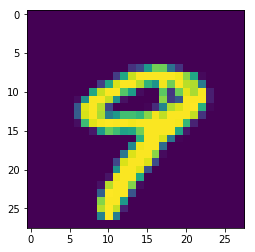

In [121]:
single_image = mnist.test.images[9].reshape(28, 28)
%matplotlib inline
plt.imshow(single_image)

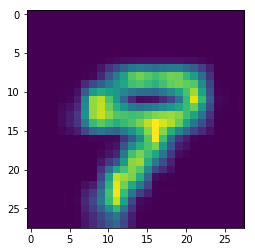

In [122]:
plt.imshow(blur_img(single_image, 2.5))

In [263]:
def load_batch(size, blur):
    batch_x, batch_y = [], []
    for _ in range(size):
        rand_val = random.randrange(0, len(mnist.train.images))
        if blur:
            batch_x.append(np.array(blur_img(mnist.train.images[rand_val].reshape(28,28), blur_level=2+random.random())).ravel())
        else:
            batch_x.append(np.array(mnist.train.images[rand_val].reshape(28,28)).ravel())
        batch_y.append(np.array(mnist.train.images[rand_val]).reshape(28,28).ravel())
    return batch_x, batch_y

In [264]:
IMGSIZE = 28
COLOR_CHANNELS = 1
print(IMGSIZE)
data_ph = tf.placeholder('float32',[None, IMGSIZE*IMGSIZE*COLOR_CHANNELS])
output_ph = tf.placeholder('float32',[None, IMGSIZE*IMGSIZE*COLOR_CHANNELS])
learning_rate = tf.placeholder('float', [], name = 'learning_rate_ph')
batch_s = tf.placeholder('int32', [], name = 'batch_size')

28


In [265]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev = 1.1)
    return tf.Variable(init_random_dist)

In [266]:
def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

In [267]:
def conv2d(x, W):
    #x -> [batch, H, W, Channels]
    #W -> [filter H, filter W, Channels IN, Channels Out]
    return tf.nn.conv2d(x, W, strides = [1,1,1,1], padding='SAME')

In [268]:
def deconvolutional_layer(input_x, filter_,shape):
    filter_ = init_weights(filter_)
    b = init_bias([shape[3]])
    return tf.nn.relu(tf.nn.conv2d_transpose(input_x, filter_, shape, strides = [1,1,1,1])+b)

In [269]:
def  convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W)+b)

In [270]:
hl0 = tf.reshape(data_ph, [-1, IMGSIZE, IMGSIZE, 1], name='aa')
hl1 = convolutional_layer(hl0, [5, 5, 1, 9])
hlnorm = tf.layers.batch_normalization(hl1)
hl2 = deconvolutional_layer(hlnorm, [5, 5, 5, 9], shape=(batch_s, 28, 28, 5))
hlnorm = tf.layers.batch_normalization(hl2)
hl3 = convolutional_layer(hlnorm, [3, 3, 5, 1])
ol = tf.nn.sigmoid(hl3)
ol = tf.reshape(ol, [-1, IMGSIZE*IMGSIZE*COLOR_CHANNELS], name = 'bb')

mean1, var1 = tf.nn.moments(output_ph, axes=[0])
mean2, var2 = tf.nn.moments(ol, axes=[0])
# print(mean.shape)
loss = tf.reduce_mean((ol - output_ph)**2)#+(tf.reduce_mean(mean2)-tf.reduce_mean(mean1))**2
train = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [271]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

<IPython.core.display.Javascript object>


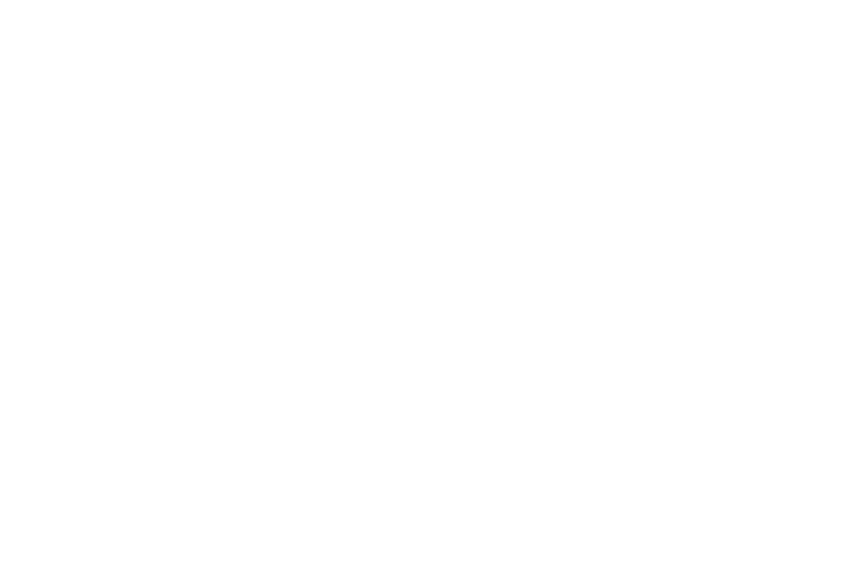

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


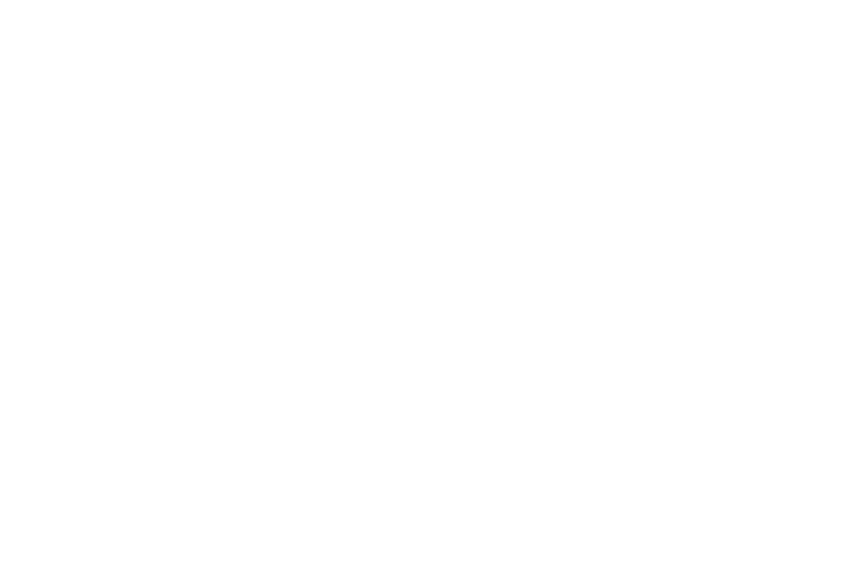

In [272]:
%matplotlib notebook
import time

start = time.time()
batch_size = 50
steps = 550000
rate = 3e-3

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

with tf.Session() as sess:
    sess.run(init)
    for i in range(steps):
        batch_x, batch_y = load_batch(batch_size, blur=True)
        feed = {data_ph:batch_x, output_ph:batch_y, batch_s:batch_size, learning_rate:rate}
        sess.run(train, feed_dict=feed)
        
        if i%100 == 0:
            last_loss = sess.run(loss, feed_dict = feed)
#             print(last_loss)
            if last_loss<0.0055:
                rate = 3e-5
            pred = sess.run(ol, feed_dict={data_ph:[np.array(blur_img(single_image, blur_level=2.5)).ravel()], batch_s:1})
#             pred = sess.run(ol, feed_dict={data_ph:[np.array(single_image).ravel()]})
            ax.clear()
            ax.imshow(np.reshape(pred, [IMGSIZE, IMGSIZE]))
            fig.canvas.draw()

end = time.time()
elapsed = end - start
print(elapsed)

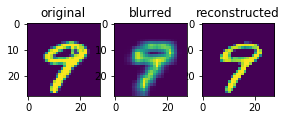

In [273]:
%matplotlib inline
fig = plt.figure()
ax1 = fig.add_subplot(1,4,1)
ax1.imshow(single_image)
ax1.set_title('original')
ax2 = fig.add_subplot(1,4,3)
ax2.imshow(np.reshape(pred, [IMGSIZE,IMGSIZE]))
ax2.set_title('reconstructed')
ax3 = fig.add_subplot(1,4,2)
ax3.imshow(blur_img(single_image, blur_level=2.5))
ax3.set_title('blurred')